In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/active"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/active


In [ ]:
import pandas as pd
origdata = pd.read_csv("pcmdata.csv",index_col=0)
#origdata['new'] = 0
origdata[:2]

,target,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,bit10,bit11,bit12,bit13,bit14,bit15,bit16,bit17,bit18,bit19,bit20,bit22,bit23,bit24,bit25,bit26,bit27,bit28,bit29,bit30,bit31,bit32,bit33,bit34,bit35,bit36,bit37,bit38,bit39,...,dp343,dp344,dp345,dp346,dp347,dp348,dp349,dp350,dp351,dp352,dp353,dp354,dp355,dp356,dp357,dp358,dp359,dp360,dp361,dp362,dp365,dp366,dp370,dp381,dp382,dp383,dp384,dp385,dp386,dp389,dp391,dp392,dp393,dp394,dp395,dp396,dp397,dp398,class,activity
compound,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHEMBL4216101,fipv,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,...,0.0,0.653595,0.0,0.653595,0.0,1.30719,0.0,0.980392,0.326797,1.633987,0.0,0.0,1.30719,0.653595,0.326797,0.980392,0.0,0.653595,0.326797,0.0,0.326797,0.0,0.326797,0.326797,0.0,0.0,0.980392,0.326797,1.633987,0.326797,0.326797,0.326797,0.0,0.0,0.0,0.326797,0.0,0.326797,1,5.17
CHEMBL4212620,fipv,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,...,0.0,0.653595,0.0,0.653595,0.0,1.30719,0.0,0.980392,0.326797,1.633987,0.0,0.0,1.30719,0.653595,0.326797,0.980392,0.0,0.653595,0.326797,0.0,0.326797,0.0,0.326797,0.326797,0.0,0.0,0.980392,0.326797,1.633987,0.326797,0.326797,0.326797,0.0,0.0,0.0,0.326797,0.0,0.326797,1,5.26


In [ ]:
#del origdata['new'] 
#del origdata['activity']
del origdata['target'] 
del origdata['class']
origdata[:2]

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,bit10,bit11,bit12,bit13,bit14,bit15,bit16,bit17,bit18,bit19,bit20,bit22,bit23,bit24,bit25,bit26,bit27,bit28,bit29,bit30,bit31,bit32,bit33,bit34,bit35,bit36,bit37,bit38,bit39,bit40,...,dp342,dp343,dp344,dp345,dp346,dp347,dp348,dp349,dp350,dp351,dp352,dp353,dp354,dp355,dp356,dp357,dp358,dp359,dp360,dp361,dp362,dp365,dp366,dp370,dp381,dp382,dp383,dp384,dp385,dp386,dp389,dp391,dp392,dp393,dp394,dp395,dp396,dp397,dp398,activity
compound,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHEMBL4216101,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,...,0.0,0.0,0.653595,0.0,0.653595,0.0,1.30719,0.0,0.980392,0.326797,1.633987,0.0,0.0,1.30719,0.653595,0.326797,0.980392,0.0,0.653595,0.326797,0.0,0.326797,0.0,0.326797,0.326797,0.0,0.0,0.980392,0.326797,1.633987,0.326797,0.326797,0.326797,0.0,0.0,0.0,0.326797,0.0,0.326797,5.17
CHEMBL4212620,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,...,0.0,0.0,0.653595,0.0,0.653595,0.0,1.30719,0.0,0.980392,0.326797,1.633987,0.0,0.0,1.30719,0.653595,0.326797,0.980392,0.0,0.653595,0.326797,0.0,0.326797,0.0,0.326797,0.326797,0.0,0.0,0.980392,0.326797,1.633987,0.326797,0.326797,0.326797,0.0,0.0,0.0,0.326797,0.0,0.326797,5.26


In [ ]:
%cd "master/"

/content/gdrive/My Drive/active/master


In [ ]:
data = origdata.values
X = data[:,:-1]
y = data[:,-1]

In [ ]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer().fit(X)
X = normalizer.transform(X)

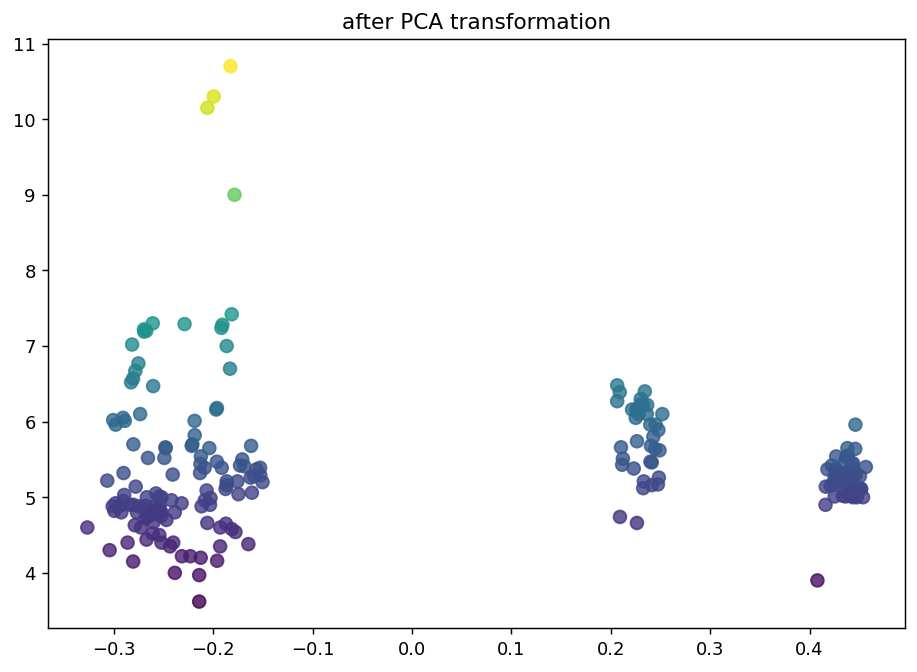

In [ ]:
from sklearn.decomposition import PCA
# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=1)
transformed = pca.fit_transform(X=X)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component = transformed[:, 0]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y, c=y, cmap='viridis', s=50, alpha=8/10)
plt.title('after PCA transformation')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling

In [52]:
# initializing the regressors
n_initial = 100
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

initial_idx = list()
initial_idx.append(np.random.choice(range(100), size=n_initial, replace=False))
initial_idx.append(np.random.choice(range(100, 200), size=n_initial, replace=False))

learner_list = [ActiveLearner(
                        estimator=GaussianProcessRegressor(kernel),
                        X_training=X[idx], y_training=y[idx]
                )
                for idx in initial_idx]

In [53]:
committee = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

In [ ]:
# active regression
n_queries = 75
performance_history = []
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X)
    committee.teach(X[query_idx], y[query_idx])
    model_accuracy = committee.learner_list[0].score(X, y)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=model_accuracy))
    performance_history.append(model_accuracy)

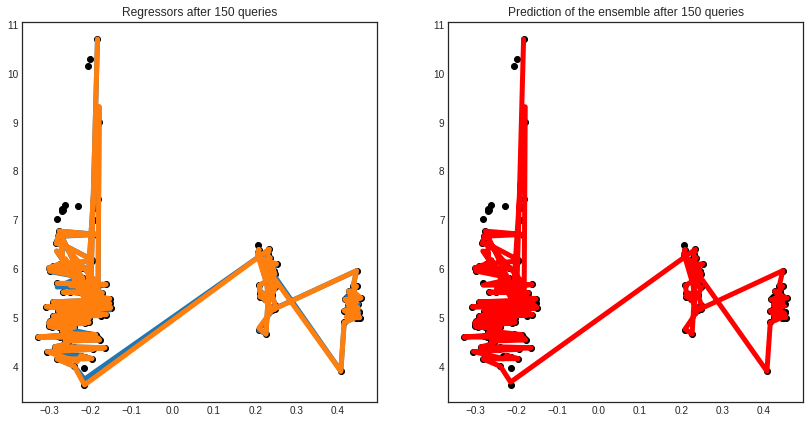

In [ ]:
# visualizing the regressors
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = X

    plt.subplot(1, 2, 1)
    for learner_idx, learner in enumerate(committee):
        plt.plot(x_component, learner.predict(x), linewidth=5)
    plt.scatter(x_component, y, c='k')
    plt.title('Regressors after %d queries' % n_queries)

    plt.subplot(1, 2, 2)
    pred, std = committee.predict(x, return_std=True)
    pred = pred.reshape(-1, )
    std = std.reshape(-1, )
    plt.plot(x_component, pred, c='r', linewidth=5)
    plt.fill_between(x_component, pred - std, pred + std, alpha=0.2)
    plt.scatter(x_component, y, c='k')
    plt.title('Prediction of the ensemble after %d queries' % n_queries)
    plt.show()

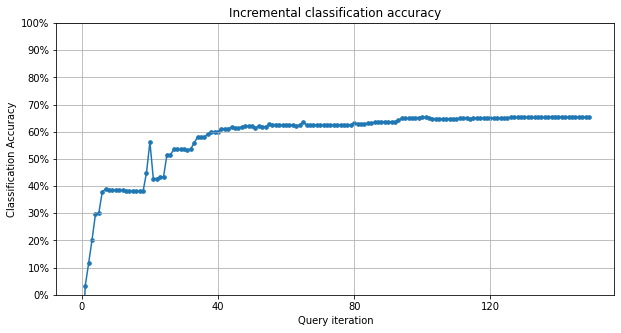

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [ ]:
from sklearn.metrics import r2_score
r2_score(y, pred)

0.6559553643538801